In [1]:
import config as cfg
import pandas as pd 
import geopandas as gpd
import logging
import numpy as np
# for plotting
import seaborn as sns
import contextily as ctx
import matplotlib.pyplot as plt
# for Moran's I
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local
from libpysal.weights import lag_spatial

'''
I am calculating Moran's I for mean household rent data (and possibly more types of data, 
like walknig time to amenities or something like that) 
to see if the distribution of rent in the districts of Madrid is dispersed randomly or if there is any clustering.

To calculate Moran's I, I use the PYSAL library to first calculate the weights 
(in this case, Queen, but I need to justify why and do some more research on this).
Then, I apply the Moran's I equation by using a built-in method: mi_income = Moran(merged['Total'], w)

Great source: https://geographicdata.science/book/notebooks/07_local_autocorrelation.html
'''


# READ DATA ------------------------------------------------------------------------------------------------------

merged = gpd.read_file(cfg.INCOME_DATA / 'geometries_and_income.geojson') # TODO: Fix path
gdf = merged[['ID', 'geometry'] + cfg.INCOME_VARS_OF_INTEREST] # here I select the variable of interest
gdf = gdf.reset_index(drop=True) # reset the index to calculate the weights with no problems


# CALCULATE WEIGHTS ---------------------------------------------------------------------------------------------

# Create spatial weights based on adjacency (Queen Contiguity)
w = Queen.from_dataframe(gdf) # TODO: Check details on how to do this properly
w.transform = 'r' # FIXME: What is this step? is it needed?

/Users/caro/Desktop/segregation-madrid/segregation_madrid_env/lib/python3.11/site-packages/pyogrio/core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()
/Users/caro/Desktop/segregation-madrid/segregation_madrid_env/lib/python3.11/site-packages/geopandas/array.py:334: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  self.crs = crs
/Users/caro/Desktop/segregation-madrid/segregation_madrid_env/lib/python3.11/site-packages/geopandas/geodataframe.py:409: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  level.crs = crs
/var/f

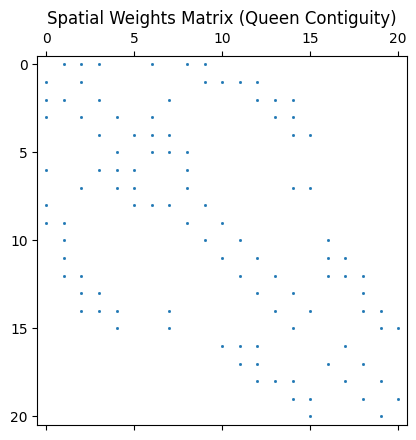

In [2]:
weights_matrix = w.full()[0]  # Extract sparse matrix
import matplotlib.pyplot as plt

plt.spy(weights_matrix, markersize=1)
plt.title("Spatial Weights Matrix (Queen Contiguity)")
plt.show()



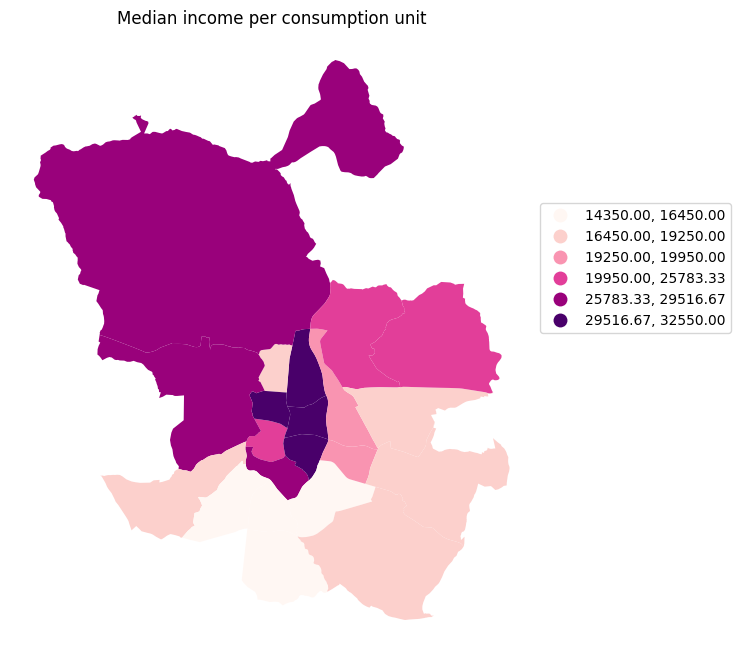

In [3]:
# Set up a single plot
f, ax = plt.subplots(figsize=(8, 8))

# Plot the map for just one variable
gdf.plot(
    column="Median income per consumption unit",
    ax=ax,
    scheme="Quantiles",
    k=6,  # Number of quantiles
    legend=True,
    legend_kwds={
        "loc": "lower left",
        "bbox_to_anchor": (1, 0.5),  # Position the legend outside the plot area
        "borderaxespad": 0.5  # Padding between the legend and the plot
    },
    linewidth=4,
    cmap="RdPu",
)

# Remove axis clutter
ax.set_axis_off()
# Set the title for the plot
ax.set_title("Median income per consumption unit")

# Display the plot
plt.show()


I am calculating Moran's I for mean household rent data (and possibly more types of data, like walknig time to amenities or something like that) to see if the distribution of rent in the districts of Madrid is dispersed randomly or if there is any clustering.

To calculate Moran's I, I use the PYSAL library to first calculate the weights (in this case, Queen, but I need to justify why and do some more research on this). Then, I apply the Moran's I equation by using a built-in method: mi_income = Moran(merged['Total'], w)

### Main source of this analysis
https://geographicdata.science/book/notebooks/07_local_autocorrelation.html

In [4]:
import config as cfg
import pandas as pd 
import geopandas as gpd
import logging
# for plotting
import seaborn as sns
import contextily as ctx
import matplotlib.pyplot as plt
from splot import esda as esdaplot
# for Moran's I
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local
from libpysal.weights import lag_spatial

merged = gpd.read_file(cfg.INCOME_DATA / 'geometries_and_income.geojson') # TODO: Fix path
gdf = merged[['ID', 'geometry'] + cfg.INCOME_VARS_OF_INTEREST] # here I select the variable of interest
gdf = gdf.reset_index(drop=True) # reset the index to calculate the weights with no problems

/Users/caro/Desktop/segregation-madrid/segregation_madrid_env/lib/python3.11/site-packages/geopandas/array.py:334: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  self.crs = crs
/Users/caro/Desktop/segregation-madrid/segregation_madrid_env/lib/python3.11/site-packages/geopandas/geodataframe.py:409: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  level.crs = crs


In [5]:
# Create spatial weights based on adjacency (Queen Contiguity)
w = Queen.from_dataframe(gdf) # TODO: Check details on how to do this properly

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_73702/1391578986.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf) # TODO: Check details on how to do this properly


In [6]:
lisa = Moran_Local(merged["Median income per consumption unit"], w)

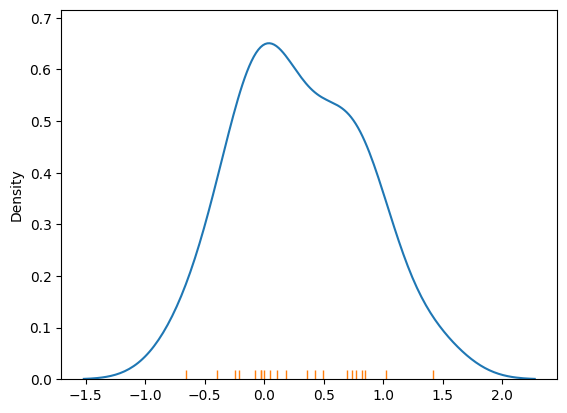

In [7]:
'''
KDE:
Here it is important to keep in mind that the high positive values arise from value similarity in space, 
and this can be due to either high values being next to high values or low values next to low values.
'''
ax = sns.kdeplot(lisa.Is)
sns.rugplot(lisa.Is, ax=ax); # representation of the morans i statistics

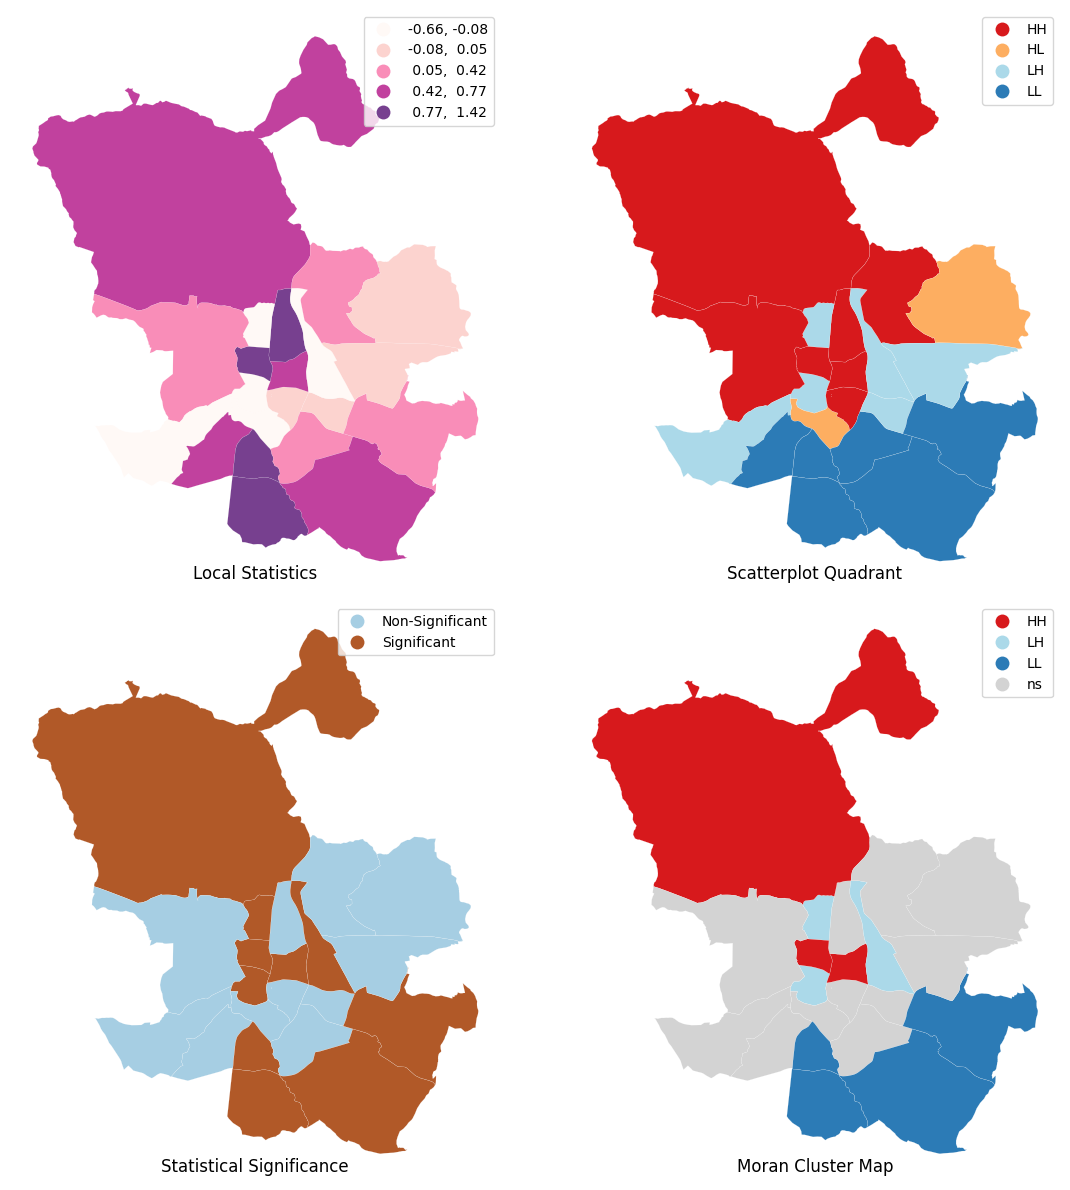

In [8]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
gdf.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="RdPu",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, gdf, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=gdf.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
gdf.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, gdf, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

In [9]:
from matplotlib.colors import ListedColormap

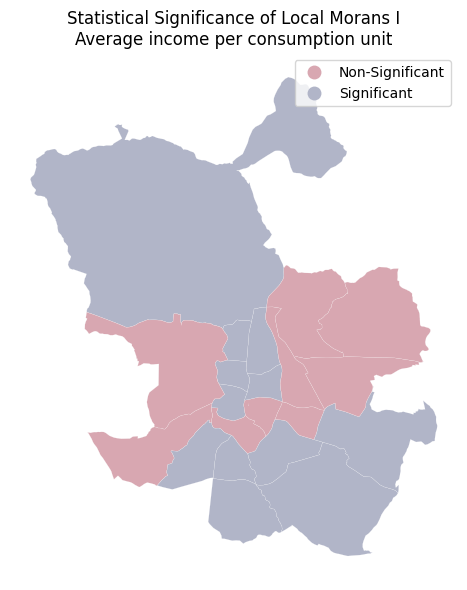

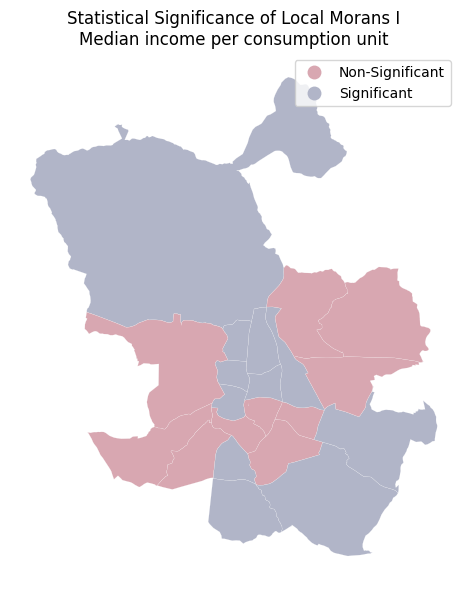

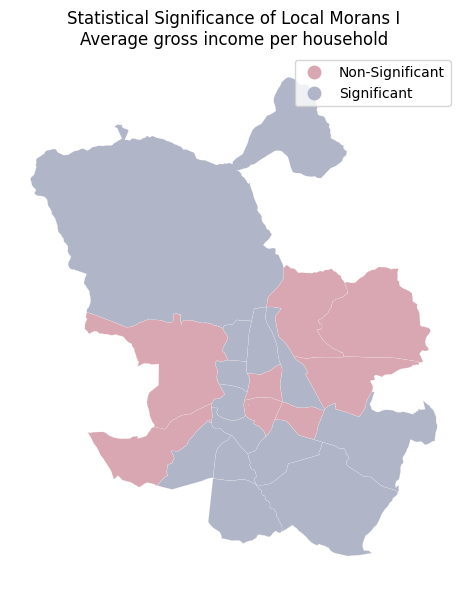

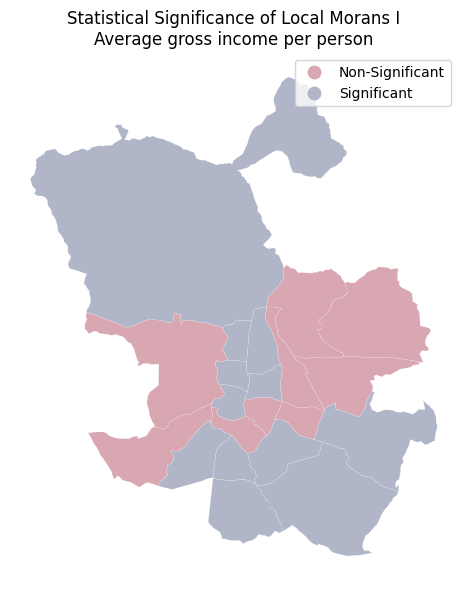

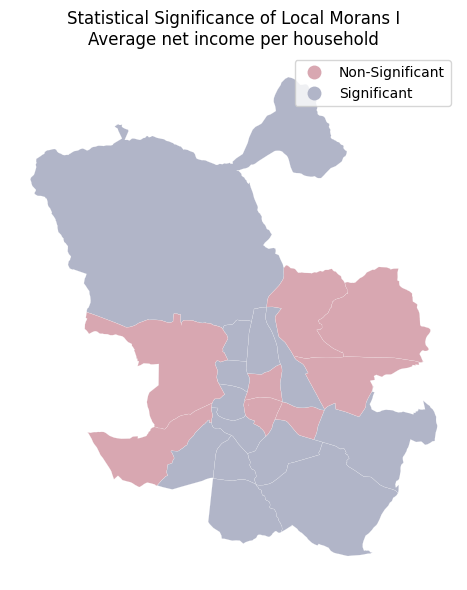

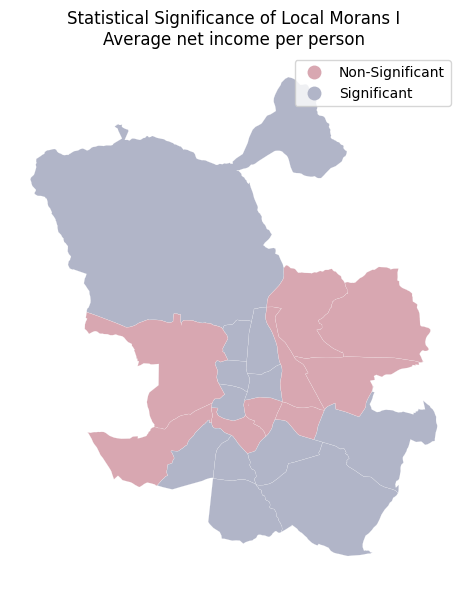

In [10]:
for var in cfg.INCOME_VARS_OF_INTEREST: 
    lisa = Moran_Local(gdf[var], w)
    fig, ax = plt.subplots(figsize=(8, 6))
    # Find out significant observations
    labels = pd.Series(
        1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
        index=gdf.index  # Use the index in the original data
        # Recode 1 to "Significant and 0 to "Non-significant"
    ).map({1: "Significant", 0: "Non-Significant"})
    # Assign labels to `db` on the fly
    gdf.assign(
        cl=labels
        # Plot choropleth of (non-)significant areas
    ).plot(
        column="cl",
        categorical=True,
        k=2,
        cmap=ListedColormap(["#D8A7B1", "#B1B5C8"]),
        linewidth=0.1,
        edgecolor="white",
        legend=True,
        ax=ax,
    )
    ax.set_title(f"Statistical Significance of Local Morans I\n{var}")

    # Turn off axis lines and ticks
    ax.set_axis_off()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

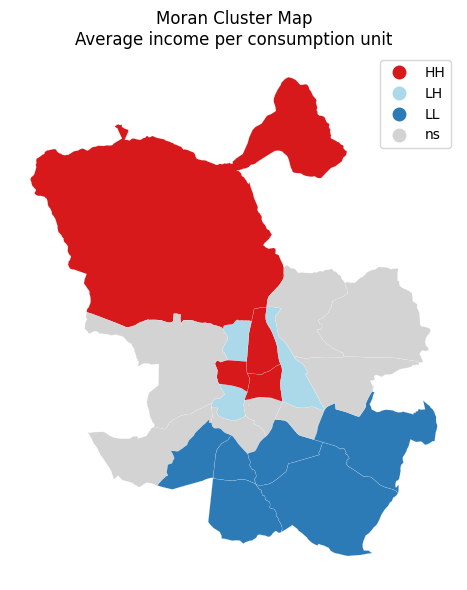

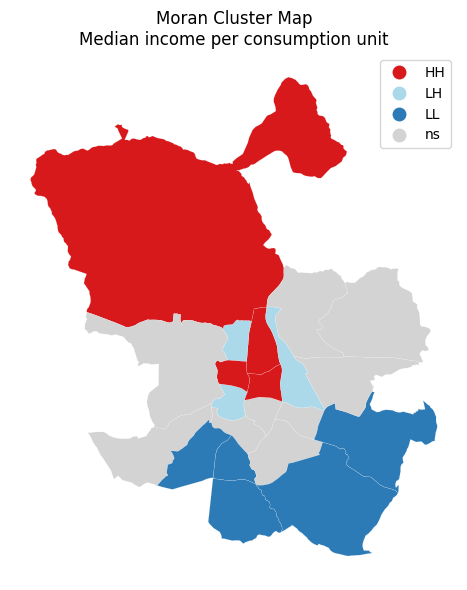

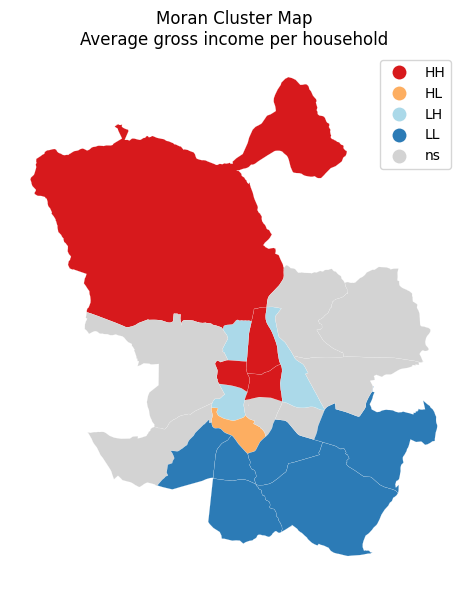

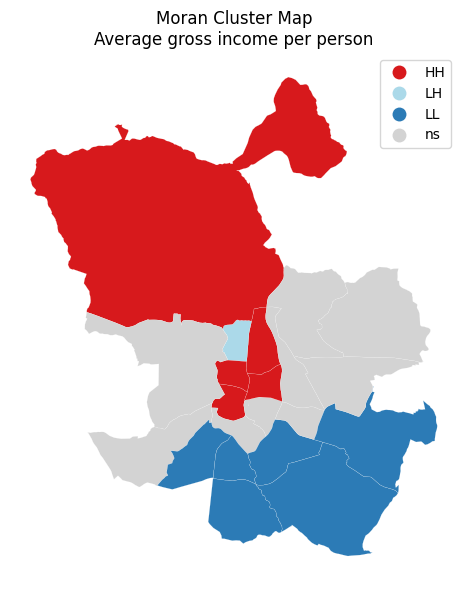

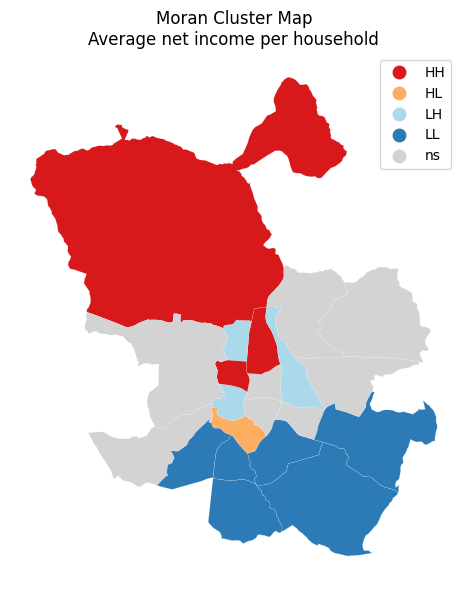

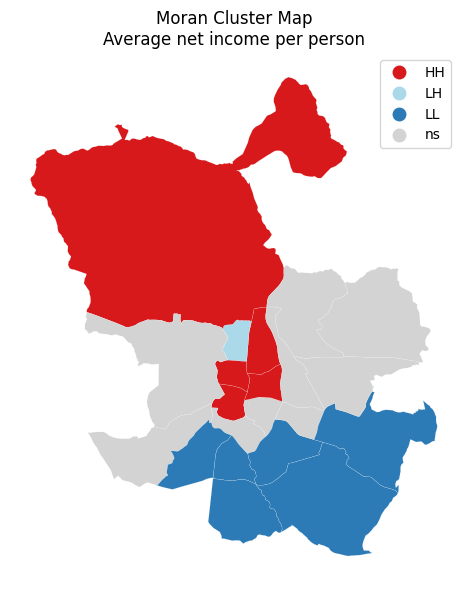

In [11]:
for var in cfg.INCOME_VARS_OF_INTEREST: 
    lisa = Moran_Local(gdf[var], w)
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot Quadrant colors In this case, we use a 5% significance
    # level to select polygons as part of statistically significant
    # clusters
    esdaplot.lisa_cluster(lisa, gdf, p=0.05, ax=ax)

    # Figure styling #
    # Set title to each subplot
    ax.set_title(f"Moran Cluster Map\n{var}")

    # Turn off axis lines and ticks
    ax.set_axis_off()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


In [12]:
w = Queen.from_dataframe(gdf) # TODO: Check details on how to do this properly
w.transform = 'r' # FIXME: What is this step? is it needed?
lisa = Moran_Local(gdf['Median income per consumption unit'], w)

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_73702/2069093294.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf) # TODO: Check details on how to do this properly


In [13]:
'''
A bit over 52% of polygons have degrees 
of local spatial association strong enough to reject the idea of pure chance.
Around 52% of the districts are considered, by this analysis, to be part of a spatial cluster.
'''
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)

np.float64(52.38095238095238)

In [14]:
for var in cfg.INCOME_VARS_OF_INTEREST: 
    lisa = Moran_Local(gdf[var], w)
    print('Var = ', var, 'Lisa = ', lisa.p_sim, 'Significance = ', (lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim))

Var =  Average income per consumption unit Lisa =  [0.011 0.05  0.385 0.023 0.014 0.003 0.011 0.016 0.296 0.411 0.029 0.007
 0.044 0.475 0.046 0.127 0.001 0.001 0.037 0.491 0.483] Significance =  61.904761904761905
Var =  Median income per consumption unit Lisa =  [0.008 0.053 0.375 0.034 0.047 0.003 0.018 0.028 0.33  0.414 0.062 0.014
 0.107 0.411 0.026 0.112 0.003 0.003 0.037 0.499 0.447] Significance =  52.38095238095238
Var =  Average gross income per household Lisa =  [0.031 0.027 0.5   0.063 0.018 0.002 0.018 0.013 0.4   0.479 0.021 0.005
 0.032 0.496 0.039 0.094 0.001 0.001 0.023 0.439 0.426] Significance =  61.904761904761905
Var =  Average gross income per person Lisa =  [0.013 0.06  0.373 0.015 0.015 0.006 0.009 0.022 0.251 0.392 0.025 0.004
 0.03  0.479 0.062 0.165 0.001 0.001 0.022 0.427 0.469] Significance =  57.142857142857146
Var =  Average net income per household Lisa =  [0.038 0.035 0.496 0.07  0.028 0.004 0.021 0.011 0.433 0.488 0.035 0.009
 0.049 0.499 0.03  0.087 0

In [15]:
lisa = Moran_Local(gdf['Median income per consumption unit'], w)
# Assign pseudo P-values to `db`
gdf["p-sim"] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
gdf["sig"] = sig

In [16]:
gdf.sig.value_counts()

sig
1    11
0    10
Name: count, dtype: int64

Let us stop for a second on these two steps. First, we consider the sig column. Akin to global Moran’s I, 
esda automatically computes a pseudo-value for each LISA. Because some instances of the LISA statistics may 
not be statistically significant, we want to identify those with a p-value small enough that rules out the possibility of 
obtaining a similar value in random maps. 
A few different ways of generating random maps are considered by esda, but we focus on a strategy that actually simulates hundreds of thousands
of random maps to get a rough idea of the possible local statistic values at each local authority given the data we saw.
In addition, we follow a similar reasoning as with global Moran’s I and use 5% as the threshold for statistical significance. 
To identify these values, we create a variable, sig, that contains True if the p-value of the observation satisfies the condition, 
and False otherwise.

In [17]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
gdf["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=gdf.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
gdf["labels"].head()

0                 LH
1    Non-Significant
2    Non-Significant
3                 HH
4                 HH
Name: labels, dtype: object

In [18]:
gdf["labels"].value_counts()

labels
Non-Significant    10
LL                  5
HH                  4
LH                  2
Name: count, dtype: int64